In [1]:
'''This script demonstrates how to build the data set for rubiks
'''
import warnings
import sys, os
from glob import glob
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.stats import norm
from skimage.transform import resize
import csv

data_dir = 'asset'
num_data = 19 # samples per viewpoint use for augmentation

# These values are allowed to change
num_tuples = int(10000) # number of actions which will be created
target_size = (30, 40)  # target image size


In [2]:
# Define 

sample_folders =  ['bag_front_state_blue',
'bag_front_state_green',
'bag_front_state_orange',
'bag_front_state_red',
'bag_front_state_white',
'bag_front_state_yellow',
'bag_left_state_blue',
'bag_left_state_green',
'bag_left_state_orange',
'bag_left_state_red',
'bag_left_state_white',
'bag_left_state_yellow',
'bag_right_state_blue',
'bag_right_state_green',
'bag_right_state_orange',
'bag_right_state_red',
'bag_right_state_white',
'bag_right_state_yellow']

def sample_cube_state(num_samples):
    ''' Sampling of the different cube states '''
    cube_colors = ['red', 'white', 'green', 'orange', 'yellow', 'blue']
    cube_opposit_sides = [['blue', 'green'], ['white','yellow'], ['orange','red'], ['green', 'blue'], ['yellow', 'white'], ['red', 'orange']]
    cube_states = {'left': [], 'front': [], 'right': []}
    # sample left color
    lookup_cube_colors = np.random.randint(0, high=len(cube_colors), size=num_samples)
    for idx in lookup_cube_colors:
        # Add the left view color
        cube_states['left'].append(cube_colors[idx])
        # Get the color of the opposit side
        cube_opposit_side_color = [color[1] for color in cube_opposit_sides if color[0] == cube_colors[idx]]
        cube_states['right'].append(cube_opposit_side_color[0])
        # Sample the front view from the remaining colors
        cube_colors_wo_left_right = cube_colors.copy()
        cube_colors_wo_left_right.remove(cube_states['left'][-1])
        cube_colors_wo_left_right.remove(cube_states['right'][-1])
        cube_states['front'].append(cube_colors_wo_left_right[np.random.randint(0, high=4, size=1)[0]])
    return cube_states

def get_iterator(batch_size, data_sub_dir = ""):
    ''' Data set iterator '''
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False,
        width_shift_range=0.0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.0)  # randomly shift images vertically (fraction of total height))

    train_generator = train_datagen.flow_from_directory(data_dir + "/" + data_sub_dir, interpolation='nearest',
            color_mode='rgb', shuffle=False, seed=None,
            target_size=target_size,
            batch_size=batch_size,
            #save_to_dir='img_0_augmented',
            class_mode=None)
    return train_generator

   
with open(data_dir + "/actions.csv", "r") as f:
    reader = csv.reader(f, delimiter=',')
    actions = [[x[0], x[1], float(x[2]), float(x[3]), float(x[4])] for x in list(reader)[1:]]
    f.close()
    
with open(data_dir + "/colors.csv", "r") as f:
    reader = csv.reader(f, delimiter=',')
    colors = list(reader)[1:]
    f.close()


In [3]:
# Read the poses and observations
X_train_set = {}
for sample_folder in sample_folders:
    X_train_set[sample_folder] = get_iterator(num_data, sample_folder).next()

Found 27 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
Found 29 images belonging to 1 classes.
Found 26 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 19 images belonging to 1 classes.
Found 21 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 25 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 33 images belonging to 1 classes.
Found 49 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


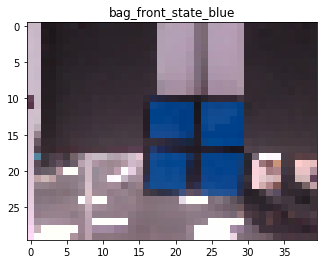

In [4]:
# Show some scaled image
plt.imshow(X_train_set['bag_front_state_blue'][0])
plt.title('bag_front_state_blue')
plt.show()

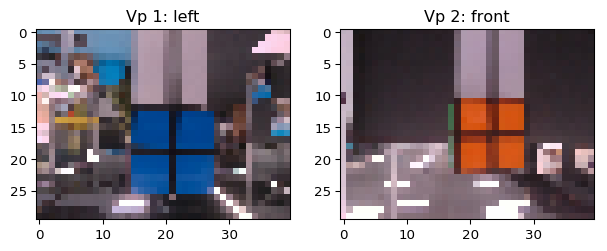

Action Vp 1 -> Vp 2:  [0.5 1.  0. ]


In [5]:
# Create the action/perception tuples
action_train = np.zeros((num_tuples, 3))
v1_train = np.zeros((num_tuples, target_size[0], target_size[1], 3))
v2_train = np.zeros((num_tuples, target_size[0], target_size[1], 3))
cube_states = sample_cube_state(num_samples = num_tuples)

lookup = np.random.randint(0, high=len(actions), size=num_tuples)
lookup_cube_state = np.random.randint(0, high=num_data, size=num_tuples)

for idx_lookup, idx in zip(lookup, range(num_tuples)):
    # Get the action for the random sample
    v1_text = actions[idx_lookup][0]
    v2_text = actions[idx_lookup][1]
    action_train[idx] = np.asarray(actions[idx_lookup][2:])
    # Get the views for the action sample and a given cube state
    random_vp_sample = np.random.randint(0, high=num_data, size=1)
    v1_train[idx,:] = X_train_set['bag_' + v1_text + '_state_' + cube_states[v1_text][idx]][random_vp_sample[0]]
    random_vp_sample = np.random.randint(0, high=num_data, size=1)
    v2_train[idx,:] = X_train_set['bag_' + v2_text + '_state_' + cube_states[v2_text][idx]][random_vp_sample[0]]

# Normalize actions
action_train = (action_train + 1.) / 2.

# Show a tuple
idx = 0
f, ax = plt.subplots(1,2,figsize=(7.5,7.5), dpi=96)
ax[0].imshow(v1_train[idx])
ax[1].imshow(v2_train[idx])
ax[0].set_title('Vp 1: ' + actions[lookup[idx]][0])
ax[1].set_title('Vp 2: ' + actions[lookup[idx]][1])
plt.show()
print("Action Vp 1 -> Vp 2: ", action_train[idx])